In [1]:
import json
import os # Import the os module for path manipulation if needed

# Define the path to the JSON file
# IMPORTANT: Make sure this path is correct for your system.
# Using os.path.expanduser('~') can help make paths more portable if the file
# is relative to the user's home directory, but for an absolute path like this,
# just ensure it's correct.
file_path = '/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/input_data_bad.json'

# --- Recursive function to find and update "Time_out" values ---
# This function handles nested dictionaries and lists within the JSON structure.
def update_time_out_values(data_item):
    """
    Recursively traverses a data structure (dictionary or list)
    and sets the value associated with the key "Time_out" to None.
    """
    if isinstance(data_item, dict):
        for key, value in data_item.items():
            if key == "Time_out":
                # Found the key, set its value to None (which becomes null in JSON)
                data_item[key] = None
            else:
                # If the value is another dict or a list, recurse into it
                update_time_out_values(value)
    elif isinstance(data_item, list):
        # If it's a list, iterate through its items and recurse
        for item in data_item:
            update_time_out_values(item)
    # Base case: If it's not a dict or list (e.g., str, int, float, bool, None), do nothing.

# --- Main execution block ---
try:
    # Step 1: Read the JSON file
    print(f"Intentando leer el archivo: {file_path}")
    with open(file_path, 'r', encoding='utf-8') as f:
        # Load the JSON data from the file into a Python object (list or dict)
        data = json.load(f)
    print("Archivo leído exitosamente.")

    # Step 2: Modify the data
    print("Modificando los valores de 'Time_out' a null...")
    # Call the recursive function to update "Time_out" values throughout the data
    update_time_out_values(data)
    print("Modificación completada en memoria.")

    # Step 3: Write the updated data back to the same file
    print(f"Intentando guardar el archivo actualizado: {file_path}")
    with open(file_path, 'w', encoding='utf-8') as f:
        # Dump the modified Python object back into the JSON file
        # ensure_ascii=False is good practice for handling non-ASCII characters
        # indent=4 makes the output JSON file human-readable (optional but recommended)
        json.dump(data, f, ensure_ascii=False, indent=4)
    print(f"¡Éxito! El archivo {file_path} ha sido actualizado.")
    print("Todos los valores asociados a la clave 'Time_out' han sido cambiados a null.")

# --- Error Handling ---
except FileNotFoundError:
    print(f"Error: No se pudo encontrar el archivo en la ruta especificada.")
    print(f"Verifica que la ruta '{file_path}' sea correcta.")
except json.JSONDecodeError:
    print(f"Error: El archivo '{file_path}' no contiene JSON válido o está corrupto.")
    print("Verifica el contenido del archivo.")
except PermissionError:
    print(f"Error: No tienes permisos para leer o escribir en el archivo '{file_path}'.")
    print("Verifica los permisos del archivo o la carpeta.")
except Exception as e:
    # Catch any other unexpected errors
    print(f"Ocurrió un error inesperado:")
    print(e)

Intentando leer el archivo: /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/input_data_bad.json
Archivo leído exitosamente.
Modificando los valores de 'Time_out' a null...
Modificación completada en memoria.
Intentando guardar el archivo actualizado: /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/input_data_bad.json
¡Éxito! El archivo /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/input_data_bad.json ha sido actualizado.
Todos los valores asociados a la clave 'Time_out' han sido cambiados a null.


In [2]:
import json
import os
from collections import defaultdict

# --- Configuration ---
# Define the paths to the JSON files
predictions_path = '/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/results/predictions_bad.json'
input_data_path = '/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/input_data_bad.json'
# Output path will be the same as the input data path, overwriting it
output_path = input_data_path

# --- Helper function to safely update dictionary ---
def safe_update_relay_data(target_relay, source_relay):
    """
    Safely updates the target relay dict with 'pick_up' and 'TDS'
    from the source relay dict, if they exist.
    """
    if source_relay:
        if 'pick_up' in source_relay:
            target_relay['pick_up'] = source_relay['pick_up']
        if 'TDS' in source_relay:
            target_relay['TDS'] = source_relay['TDS']

# --- Main execution block ---
try:
    # Step 1: Read the predictions data
    print(f"Leyendo archivo de predicciones: {predictions_path}")
    if not os.path.exists(predictions_path):
        raise FileNotFoundError(f"El archivo de predicciones no existe: {predictions_path}")
    with open(predictions_path, 'r', encoding='utf-8') as f:
        predictions_list = json.load(f)
    print("Archivo de predicciones leído.")

    # Step 2: Organize predictions for efficient lookup
    # Create a dictionary where keys are scenario_id and values are dictionaries
    # mapping pair_index to the corresponding prediction data.
    predictions_map = defaultdict(dict)
    for prediction in predictions_list:
        scenario_id = prediction.get("scenario_id")
        pair_index = prediction.get("pair_index")
        if scenario_id is not None and pair_index is not None:
            predictions_map[scenario_id][pair_index] = prediction
        else:
            print(f"Advertencia: Entrada de predicción omitida por falta de 'scenario_id' o 'pair_index': {prediction}")
    print("Datos de predicciones organizados para búsqueda.")

    # Step 3: Read the input data file
    print(f"Leyendo archivo de datos de entrada: {input_data_path}")
    if not os.path.exists(input_data_path):
        raise FileNotFoundError(f"El archivo de datos de entrada no existe: {input_data_path}")
    with open(input_data_path, 'r', encoding='utf-8') as f:
        input_data_list = json.load(f)
    print("Archivo de datos de entrada leído.")

    # Step 4: Merge the data
    print("Iniciando la combinación de datos...")
    # Keep track of the pair index for each scenario as we iterate through input_data
    scenario_pair_counters = defaultdict(int)
    skipped_entries = 0
    updated_entries = 0

    for input_entry in input_data_list:
        scenario_id = input_entry.get("scenario_id")

        if not scenario_id:
            print(f"Advertencia: Entrada de datos omitida por falta de 'scenario_id': {input_entry}")
            skipped_entries += 1
            continue

        # Determine the current pair index for this scenario based on the order in the input file
        current_pair_index = scenario_pair_counters[scenario_id]
        scenario_pair_counters[scenario_id] += 1 # Increment for the next entry of the same scenario

        # Find the corresponding prediction data
        prediction_data = predictions_map.get(scenario_id, {}).get(current_pair_index)

        if prediction_data:
            # Update main relay data if it exists in both entries
            if 'main_relay' in input_entry:
                safe_update_relay_data(input_entry['main_relay'], prediction_data.get('main_relay'))

            # Update backup relay data if it exists in both entries
            if 'backup_relay' in input_entry:
                 safe_update_relay_data(input_entry['backup_relay'], prediction_data.get('backup_relay'))

            updated_entries += 1
        else:
            # Optional: Add a warning if no matching prediction was found for an input entry
            # This might happen if the number of pairs per scenario differs between files
            # or if scenario_ids don't match.
            print(f"Advertencia: No se encontraron datos de predicción para scenario_id='{scenario_id}', pair_index={current_pair_index} (índice basado en orden).")
            skipped_entries += 1

    print(f"Combinación completada. Entradas actualizadas: {updated_entries}, Entradas omitidas/sin coincidencia: {skipped_entries}")

    # Step 5: Write the updated data back to the input file (overwrite)
    print(f"Guardando los datos actualizados en: {output_path}")
    with open(output_path, 'w', encoding='utf-8') as f:
        # Use indent=4 for readability
        json.dump(input_data_list, f, ensure_ascii=False, indent=4)
    print(f"¡Éxito! El archivo {output_path} ha sido actualizado con los valores de 'pick_up' y 'TDS'.")

# --- Error Handling ---
except FileNotFoundError as e:
    print(f"Error: Archivo no encontrado.")
    print(e)
except json.JSONDecodeError as e:
    print(f"Error: Falla al decodificar JSON. Verifica que ambos archivos sean JSON válidos.")
    print(f"Detalles del error: {e}")
except KeyError as e:
    print(f"Error: Falta una clave esperada en los datos.")
    print(f"Clave faltante: {e}")
    print("Verifica la estructura de tus archivos JSON.")
except Exception as e:
    # Catch any other unexpected errors
    print(f"Ocurrió un error inesperado:")
    print(e)

Leyendo archivo de predicciones: /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/results/predictions_bad.json
Archivo de predicciones leído.
Datos de predicciones organizados para búsqueda.
Leyendo archivo de datos de entrada: /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/input_data_bad.json
Archivo de datos de entrada leído.
Iniciando la combinación de datos...
Combinación completada. Entradas actualizadas: 3400, Entradas omitidas/sin coincidencia: 0
Guardando los datos actualizados en: /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/input_data_bad.json
¡Éxito! El archivo /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/input_data_bad.json ha sido actualizado con los valores de 'pick_up' y 'TDS'.


# calculo del TMT

In [5]:
import json
import math
import os
from collections import defaultdict # Import defaultdict for easier summing per scenario

# --- Configuration ---
# Path to the JSON file (updated in previous steps)
input_data_path = '/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/input_data_bad.json'
# Output path will be the same, overwriting the file
output_path = input_data_path

# --- Constants for Calculation ---
# IEC Standard Normal Inverse Curve parameters
K = 0.14
N = 0.02
# Coordination Time Interval (CTI) in seconds
CTI = 0.25

# --- Function to calculate operation time ---
# (Function remains the same as previous version)
def calculate_operation_time(I_shc, I_pi, TDS, relay_id="N/A"):
    if I_shc is None or I_pi is None or TDS is None: return float('inf')
    if not all(isinstance(x, (int, float)) for x in [I_shc, I_pi, TDS]): return float('inf')
    if I_pi <= 0: return float('inf')
    if TDS <= 0: return float('inf')
    try:
        M = I_shc / I_pi
        if M <= 1: return float('inf')
        denominator = (M**N) - 1
        if denominator <= 1e-9: return float('inf')
        time = (K / denominator) * TDS
        return max(0.0, time)
    except (ZeroDivisionError, OverflowError, ValueError):
        return float('inf')

# --- Main execution block ---
try:
    # Step 1: Read the input data file
    print(f"Leyendo archivo de datos: {input_data_path}")
    if not os.path.exists(input_data_path):
        raise FileNotFoundError(f"El archivo de datos de entrada no existe: {input_data_path}")
    with open(input_data_path, 'r', encoding='utf-8') as f:
        data_list = json.load(f)
    print("Archivo de datos leído.")

    # Step 2: Iterate, calculate, handle values, and sum MT per scenario
    print(f"Iniciando cálculos (K={K}, N={N}, CTI={CTI})...")

    # Counters for overall summary
    processed_pairs = 0
    coordinated_count = 0
    miscoordinated_count = 0
    invalid_or_no_op_count = 0

    # Dictionary to store TMT sum per scenario
    # defaultdict(float) initializes new keys with 0.0
    scenario_tmt_totals = defaultdict(float)

    for entry in data_list:
        processed_pairs += 1
        main_relay_data = entry.get('main_relay')
        backup_relay_data = entry.get('backup_relay')
        # Get scenario ID early, use a default if missing
        scenario_id = entry.get('scenario_id', 'ID_Desconocido')

        if not main_relay_data or not backup_relay_data:
            print(f"Advertencia: Entrada {processed_pairs} (Escenario: {scenario_id}) omitida por falta de 'main_relay' o 'backup_relay'.")
            if main_relay_data: main_relay_data['Time_out'] = None
            if backup_relay_data: backup_relay_data['Time_out'] = None
            entry['delta_t'] = None
            entry['MT'] = None
            invalid_or_no_op_count += 1
            continue # Skip to next entry

        main_relay_id = main_relay_data.get('relay', 'Principal_Desconocido')
        backup_relay_id = backup_relay_data.get('relay', 'Respaldo_Desconocido')

        # --- Get values and Force Positive Pickup/TDS ---
        I_shc_main = main_relay_data.get('Ishc')
        I_pi_main = main_relay_data.get('pick_up')
        TDS_main = main_relay_data.get('TDS')
        I_shc_backup = backup_relay_data.get('Ishc')
        I_pi_backup = backup_relay_data.get('pick_up')
        TDS_backup = backup_relay_data.get('TDS')

        if I_pi_main is not None and isinstance(I_pi_main, (int, float)): I_pi_main = abs(I_pi_main)
        if TDS_main is not None and isinstance(TDS_main, (int, float)): TDS_main = abs(TDS_main)
        if I_pi_backup is not None and isinstance(I_pi_backup, (int, float)): I_pi_backup = abs(I_pi_backup)
        if TDS_backup is not None and isinstance(TDS_backup, (int, float)): TDS_backup = abs(TDS_backup)
        # --- End forcing positive ---

        t_m_ref = calculate_operation_time(I_shc_main, I_pi_main, TDS_main, main_relay_id)
        t_b_ref = calculate_operation_time(I_shc_backup, I_pi_backup, TDS_backup, backup_relay_id) # Using Backup Ishc

        main_relay_data['Time_out'] = t_m_ref if t_m_ref != float('inf') else None
        backup_relay_data['Time_out'] = t_b_ref if t_b_ref != float('inf') else None

        delta_t = None
        mt = None

        if t_m_ref != float('inf') and t_b_ref != float('inf'):
            delta_t = t_b_ref - t_m_ref - CTI
            mt = min(0.0, (delta_t - abs(delta_t)) / 2)

            # --- Accumulate MT per scenario ---
            # Add MT to the total for this specific scenario *only if* it's negative
            if mt < 0:
                 scenario_tmt_totals[scenario_id] += mt
            # --- End Accumulate ---

            if delta_t >= 0:
                coordinated_count += 1
            else:
                miscoordinated_count += 1
        else:
            invalid_or_no_op_count += 1

        entry['delta_t'] = delta_t
        entry['MT'] = mt
        # End of loop for one entry

    print(f"Cálculos completados para {processed_pairs} entradas totales.")

    # Step 3: Print Summary per Scenario
    print("\n--- Suma de Miscoordination Time (TMT) por Escenario ---")
    if scenario_tmt_totals:
        # Sort scenarios by ID for consistent output order
        sorted_scenarios = sorted(scenario_tmt_totals.items())
        for scenario_id, tmt in sorted_scenarios:
            print(f"  - Escenario '{scenario_id}': tmt_total = {tmt:.4f}")
    else:
        print("  No se registraron valores de TMT negativos en ningún escenario.")
    print("----------------------------------------------------\n")


    # Step 4: Print Overall Summary
    print("--- Resumen General de Coordinación (Todos los Escenarios) ---")
    print(f"Total de Pares Procesados: {processed_pairs}")
    print(f"  - Pares Coordinados (delta_t >= 0): {coordinated_count}")
    print(f"  - Pares Descoordinados (delta_t < 0): {miscoordinated_count}")
    print(f"  - Pares Inválidos/Sin Operación (tiempo infinito o datos faltantes): {invalid_or_no_op_count}")
    print(f"----------------------------------------------------------")
    # Verification check
    if processed_pairs != (coordinated_count + miscoordinated_count + invalid_or_no_op_count):
         print("ADVERTENCIA: El conteo de pares no coincide con el total procesado.")
    print("") # Add a newline for spacing

    # Step 5: Write the updated data (with individual Time_out, delta_t, MT per pair) back to the file
    print(f"Guardando los datos actualizados en: {output_path}")
    with open(output_path, 'w', encoding='utf-8') as f:
        # The main JSON file still contains the list of pairs, each updated.
        # The per-scenario TMT totals are only printed, not added back to this file.
        json.dump(data_list, f, ensure_ascii=False, indent=4)
    print(f"¡Éxito! El archivo {output_path} ha sido actualizado con los datos por par.")

# --- Error Handling ---
except FileNotFoundError as e: print(f"Error: Archivo no encontrado.\n{e}")
except json.JSONDecodeError as e: print(f"Error: Falla al decodificar JSON en {input_data_path}.\nDetalles: {e}")
except KeyError as e: print(f"Error: Falta una clave esperada en los datos JSON.\nClave faltante: {e}")
except TypeError as e: print(f"Error de tipo: Probablemente un valor None o tipo incorrecto.\nDetalles: {e}")
except Exception as e: print(f"Ocurrió un error inesperado:\n{e}")

Leyendo archivo de datos: /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/input_data_bad.json
Archivo de datos leído.
Iniciando cálculos (K=0.14, N=0.02, CTI=0.25)...
Cálculos completados para 3400 entradas totales.

--- Suma de Miscoordination Time (TMT) por Escenario ---
  - Escenario 'scenario_10': tmt_total = -62.9120
  - Escenario 'scenario_11': tmt_total = -69.6442
  - Escenario 'scenario_12': tmt_total = -62.4626
  - Escenario 'scenario_13': tmt_total = -64.3786
  - Escenario 'scenario_14': tmt_total = -55.2419
  - Escenario 'scenario_15': tmt_total = -43.1925
  - Escenario 'scenario_16': tmt_total = -46.5251
  - Escenario 'scenario_17': tmt_total = -51.8726
  - Escenario 'scenario_18': tmt_total = -53.9080
  - Escenario 'scenario_19': tmt_total = -63.8215
  - Escenario 'scenario_2': tmt_total = -45.6686
  - Escenario 'scenario_20': tmt_total = -46.3023
  - Escenario 'scenario_3': tmt_total = -43.8514
  - Escenario 'scenario_37': tmt_total = 

In [14]:
#!/usr/bin/env python3
"""
Genera:
  • summary_scenarios.csv  –  métrica global por escenario
  • mt_distribution.csv    –  |mt| de cada par descoordinado
Notas:
  – TMT se define como la suma de mt (siempre negativo) y es adimensional.
  – CTI fijo en 0.2 s.
"""
import json, csv, os
CTI = 0.2
INPUT_FILE = "/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/independent_relay_pairs_best.json"
OUT_CSV_SCEN = "summary_scenarios_transformer.csv"
OUT_CSV_MT   = "mt_distribution_transformer.csv"

with open(INPUT_FILE) as f:
    data = json.load(f)

per_scenario = {}
for p in data:
    sid = p["scenario_id"]
    d = per_scenario.setdefault(sid, {"total":0,"valid":0,"descoord":0,"TMT":0.0})
    d["total"] += 1
    tm, tb = p["main_relay"].get("Time_out"), p["backup_relay"].get("Time_out")
    if not all(isinstance(x,(int,float)) for x in (tm, tb)):
        continue
    d["valid"] += 1
    delta_t = tb - tm - CTI
    mt = (delta_t - abs(delta_t))/2        # negativo si Δt<0
    if delta_t < 0:
        d["descoord"] += 1
        d["TMT"]      += mt                # suma valores negativos
        # exportar |mt| para gráfica de distribución
        with open(OUT_CSV_MT,"a",newline="") as g:
            csv.writer(g).writerow([
                sid,
                f'{p["fault"]}% {p["main_relay"]["relay"]}/{p["backup_relay"]["relay"]}',
                abs(mt)
            ])

with open(OUT_CSV_SCEN,"w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["Escenario","Pares evaluados","Pares válidos",
                "Descoordinados","% Descoord","TMT (negativo)"])
    for sid,d in sorted(per_scenario.items(),
                        key=lambda k:int(k[0].split("_")[-1])):
        pct = 100*d["descoord"]/d["valid"] if d["valid"] else 0
        w.writerow([sid,d["total"],d["valid"],d["descoord"],
                    f"{pct:.1f}",f"{d['TMT']:.5f}"])
print("✓ summary_scenarios.csv y mt_distribution.csv listos")


✓ summary_scenarios.csv y mt_distribution.csv listos


# graph


In [15]:
#!/usr/bin/env python3
"""
Lee summary_scenarios.csv y genera:
  • tmt_by_scenario.png  –  gráfica en barras del TMT (negativo)
"""
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Cargar CSV ---
df = pd.read_csv("summary_scenarios_transformer.csv")

# --- 2. Extraer número de escenario y ordenar ---
df["num"] = pd.to_numeric(df["Escenario"].str.extract(r"(\d+)")[0])
df = df.sort_values("num")

# --- 3. Graficar ---
plt.figure(figsize=(12,5))
plt.bar(df["Escenario"], df["TMT (negativo)"])
plt.title("TMT por escenario (68 escenarios)")
plt.xlabel("Escenario")
plt.ylabel("TMT")
plt.xticks(rotation=90)
plt.tight_layout()

# --- 4. Guardar como PNG (300 dpi) ---
plt.savefig("tmt_by_scenario_transformer.png", dpi=300)
plt.close()

print("✓ tmt_by_scenario_transformer.png generado")


✓ tmt_by_scenario_transformer.png generado


# grap v2

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Lee TDS_Pickup_nuevos.csv con columnas:
  escenario,par_rele,TDS_principal,Pickup_principal,TDS_respaldo,Pickup_respaldo
Calcula TM = Pickup_respaldo − Pickup_principal − CTI
y agrupa los TM negativos para obtener TMT por escenario.
Dibuja un bar chart de TMT por escenario.
"""

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ─── Configuración de rutas y constantes ────────────────────────────────
BASE   = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/")
CSV_IN = BASE / "data/processed/model/results/TDS_Pickup_nuevos.csv"
PNG_OUT = BASE / "data/processed/model/results/tmt_by_scenario_prueba_v2.png"
CTI    = 0.2

# ─── 1) Cargar CSV ───────────────────────────────────────────────────────
df = pd.read_csv(CSV_IN)

# ─── 2) Calcular TM (margen de tiempo usando pickup) ────────────────────
# df["TM"] = df["Pickup_respaldo"] - df["Pickup_principal"] - CTI
#2) Calcular TM (margen de tiempo usando time out)


# ─── 3) Agrupar para obtener TMT (suma de TM negativos) ─────────────────
summary = (
    df.groupby("escenario")["TM"]
      .apply(lambda x: x[x < 0].sum())
      .reset_index()
      .rename(columns={"TM": "TMT (negativo)"})
)

# Extraer número de escenario para ordenarlo
summary["num"] = summary["escenario"].str.extract(r"(\d+)").astype(int)
summary = summary.sort_values("num")

# ─── 4) Gráfica de barras ───────────────────────────────────────────────
plt.figure(figsize=(12, 5))
plt.bar(summary["escenario"], summary["TMT (negativo)"])
plt.title("TMT por escenario (prueba)")
plt.xlabel("Escenario")
plt.ylabel("TMT (suma de márgenes negativos)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(PNG_OUT, dpi=300)
plt.show()

print(f"Gráfica guardada en: {PNG_OUT}")


FileNotFoundError: [Errno 2] No such file or directory: '/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/results/TDS_Pickup_nuevos.csv'

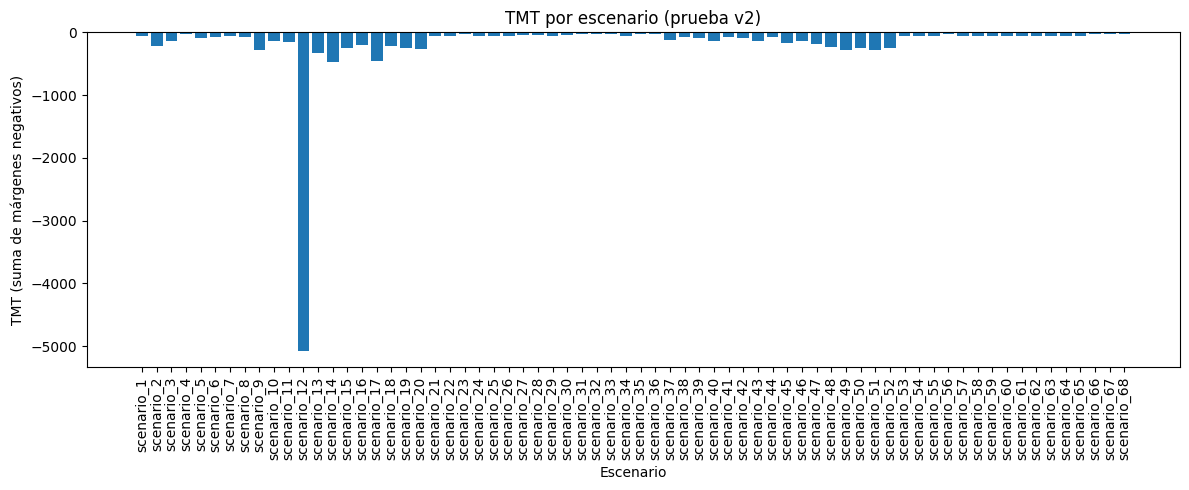

Gráfica guardada en: /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/results/tmt_by_scenario_prueba_v2.png


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Lee los nuevos ajustes de TDS/pickup, recalcula Time_out con la función
calculate_operation_time, obtiene delta_t y mt para cada par, agrupa
los mt negativos en TMT por escenario y dibuja un bar chart.
"""

import json
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from pathlib import Path

# ─────────────────────────── CONSTANTES ───────────────────────────
K = 0.14
N = 0.02
DECIMAL_PLACES = 4
CTI = 0.2

def calculate_operation_time(I_shc, I_pi, TDS):
    if not all(isinstance(x, (int, float)) for x in [I_shc, I_pi, TDS]):
        return 0.0
    if any(x is None or x <= 0 for x in [I_pi, TDS]) or I_shc <= 0:
        return 0.0
    try:
        if abs(I_pi) < 1e-9:
            return 0.0
        M = I_shc / I_pi
    except ZeroDivisionError:
        return 0.0
    if M <= 1:
        return 0.0
    try:
        denominator = M**N - 1
        if abs(denominator) < 1e-9:
            return 0.0
        timeout = (K / denominator) * TDS
        return round(timeout, DECIMAL_PLACES) if np.isfinite(timeout) else 0.0
    except (OverflowError, ValueError):
        return 0.0

# ─────────────────────────── RUTAS ───────────────────────────
BASE    = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/")
JSON_IN = BASE / "data/processed/independent_relay_pairs_transformer.json"
CSV_IN  = BASE / "data/processed/model/results/TDS_Pickup_nuevos.csv"
PNG_OUT = BASE / "data/processed/model/results/tmt_by_scenario_prueba_v2.png"

# ────────────────── 1) Carga de pares originales ──────────────────
with open(JSON_IN, "r") as f:
    pairs = json.load(f)

# Asignar par_rele en orden de aparición
counts = {}
for pair in pairs:
    sid = pair["scenario_id"]
    counts[sid] = counts.get(sid, 0) + 1
    pair["par_rele"] = counts[sid]

# ────────────────── 2) Leer CSV y construir mapa de ajustes ────────
df_new = pd.read_csv(CSV_IN)
new_map = {
    (row["escenario"], row["par_rele"]): row.to_dict()
    for _, row in df_new.iterrows()
}

# ────────────────── 3) Recalcular timeouts y márgenes ────────────
for pair in pairs:
    key = (pair["scenario_id"], pair["par_rele"])
    ajustes = new_map.get(key)

    main = pair["main_relay"]
    back = pair["backup_relay"]

    if ajustes:
        main["TDS"]     = ajustes["TDS_principal"]
        main["pick_up"] = ajustes["Pickup_principal"]
        back["TDS"]     = ajustes["TDS_respaldo"]
        back["pick_up"] = ajustes["Pickup_respaldo"]

    main_time   = calculate_operation_time(main.get("Ishc"), main.get("pick_up"), main.get("TDS"))
    back_time   = calculate_operation_time(back.get("Ishc"), back.get("pick_up"), back.get("TDS"))
    pair["main_time"]   = main_time
    pair["backup_time"] = back_time

    delta_t = back_time - main_time - CTI
    mt = (delta_t - abs(delta_t)) / 2
    pair["delta_t"] = delta_t
    pair["mt"]      = mt

# ────────────────── 4) Agregar mt negativo a TMT por escenario ──────
per_scenario = {}
for p in pairs:
    sid = p["scenario_id"]
    d = per_scenario.setdefault(sid, {"TMT": 0.0})
    mt = p.get("mt", 0.0)
    if isinstance(mt, float) and mt < 0:
        d["TMT"] += mt

# ────────────────── 5) Construir DataFrame de resumen ───────────────
summary = [
    {"Escenario": sid, "TMT (negativo)": vals["TMT"]}
    for sid, vals in sorted(per_scenario.items(),
                            key=lambda x: int(x[0].split("_")[-1]))
]
df_summary = pd.DataFrame(summary)

# ────────────────── 6) Graficar TMT por escenario ────────────────────
plt.figure(figsize=(12,5))
plt.bar(df_summary["Escenario"], df_summary["TMT (negativo)"])
plt.title("TMT por escenario (prueba v2)")
plt.xlabel("Escenario")
plt.ylabel("TMT (suma de márgenes negativos)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(PNG_OUT, dpi=300)
plt.show()

print(f"Gráfica guardada en: {PNG_OUT}")


In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Calcula Time_out, delta_t y mt para cada par, suma los mt negativos
en TMT por escenario y dibuja un bar chart interactivo con Plotly.
"""

import json
import numpy as np
import pandas as pd
import copy
import plotly.express as px
from pathlib import Path

# ─────────────────────────── CONSTANTES ───────────────────────────
K = 0.14
N = 0.02
DECIMAL_PLACES = 4
CTI = 0.2

def calculate_operation_time(I_shc, I_pi, TDS):
    if not all(isinstance(x, (int, float)) for x in (I_shc, I_pi, TDS)):
        return 0.0
    if any(x is None or x <= 0 for x in (I_pi, TDS)) or I_shc <= 0:
        return 0.0
    try:
        if abs(I_pi) < 1e-9:
            return 0.0
        M = I_shc / I_pi
    except ZeroDivisionError:
        return 0.0
    if M <= 1:
        return 0.0
    try:
        denom = M**N - 1
        if abs(denom) < 1e-9:
            return 0.0
        t = (K / denom) * TDS
        return round(t, DECIMAL_PLACES) if np.isfinite(t) else 0.0
    except (OverflowError, ValueError):
        return 0.0

# ─────────────────────────── RUTAS ───────────────────────────
BASE    = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/")
JSON_IN = BASE / "data/processed/independent_relay_pairs_transformer.json"
CSV_IN  = BASE / "data/processed/model/results/TDS_Pickup_nuevos.csv"
HTML_OUT = BASE / "data/processed/model/results/tmt_by_scenario_prueba_v2.html"
PNG_OUT  = BASE / "data/processed/model/results/tmt_by_scenario_prueba_v2.png"

# ────────────────── 1) Leer pares originales ──────────────────
with open(JSON_IN, "r") as f:
    pairs = json.load(f)

# Asignar par_rele en orden de aparición
counts = {}
for pair in pairs:
    sid = pair["scenario_id"]
    counts[sid] = counts.get(sid, 0) + 1
    pair["par_rele"] = counts[sid]

# ──────────────── 2) Leer CSV de nuevos ajustes ───────────────
df_new = pd.read_csv(CSV_IN)
new_map = {
    (int(r["escenario"].split("_")[-1]), r["par_rele"]): r.to_dict()
    for _, r in df_new.iterrows()
}

#


In [10]:
import json
import numpy as np
import pandas as pd
import plotly.express as px
from pathlib import Path

# ─────────────────────────── CONSTANTES ───────────────────────────
K = 0.14
N = 0.02
DECIMAL_PLACES = 4
CTI = 0.2

def calculate_operation_time(I_shc, I_pi, TDS):
    if not all(isinstance(x, (int, float)) for x in (I_shc, I_pi, TDS)):
        return 0.0
    if any(x is None or x <= 0 for x in (I_pi, TDS)) or I_shc <= 0:
        return 0.0
    try:
        if abs(I_pi) < 1e-9:
            return 0.0
        M = I_shc / I_pi
    except ZeroDivisionError:
        return 0.0
    if M <= 1:
        return 0.0
    try:
        denom = M**N - 1
        if abs(denom) < 1e-9:
            return 0.0
        timeout = (K / denom) * TDS
        return round(timeout, DECIMAL_PLACES) if np.isfinite(timeout) else 0.0
    except (OverflowError, ValueError):
        return 0.0

# ─────────────────────────── RUTAS ───────────────────────────
BASE    = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/")
JSON_IN = BASE / "data/processed/independent_relay_pairs_transformer.json"
CSV_IN  = BASE / "data/processed/model/results/TDS_Pickup_nuevos.csv"

# ────────────────── 1) Leer pares originales ──────────────────
with open(JSON_IN, "r") as f:
    pairs = json.load(f)

# Asignar par_rele en orden de aparición
counts = {}
for pair in pairs:
    sid = pair["scenario_id"]
    counts[sid] = counts.get(sid, 0) + 1
    pair["par_rele"] = counts[sid]

# ──────────────── 2) Leer CSV de nuevos ajustes ───────────────
df_new = pd.read_csv(CSV_IN)
new_map = {
    (row["escenario"], row["par_rele"]): row.to_dict()
    for _, row in df_new.iterrows()
}

# ──────── 3) Recalcular timeouts y márgenes y agregar mt ────────
per_scenario = {}
for pair in pairs:
    key = (pair["scenario_id"], pair["par_rele"])
    ajustes = new_map.get(key, {})

    main = pair["main_relay"]
    back = pair["backup_relay"]

    # Actualizar configuraciones
    if ajustes:
        main["TDS"]     = ajustes["TDS_principal"]
        main["pick_up"] = ajustes["Pickup_principal"]
        back["TDS"]     = ajustes["TDS_respaldo"]
        back["pick_up"] = ajustes["Pickup_respaldo"]

    # Recalcular Time_out
    mt_main = calculate_operation_time(main.get("Ishc"), main.get("pick_up"), main.get("TDS"))
    mt_back = calculate_operation_time(back.get("Ishc"), back.get("pick_up"), back.get("TDS"))

    # delta_t y mt
    delta_t = mt_back - mt_main - CTI
    mt_val  = (delta_t - abs(delta_t)) / 2

    # Acumular TMT por escenario
    d = per_scenario.setdefault(pair["scenario_id"], 0.0)
    if mt_val < 0:
        per_scenario[pair["scenario_id"]] += mt_val

# ────────────────── 4) Preparar DataFrame de resumen ──────────────
summary_df = pd.DataFrame([
    {"Escenario": esc, "TMT (negativo)": tmt}
    for esc, tmt in per_scenario.items()
])
# Ordenar por número
summary_df["num"] = summary_df["Escenario"].str.extract(r"(\d+)").astype(int)
summary_df = summary_df.sort_values("num")

# ────────────────── 5) Graficar con Plotly ───────────────────────
fig = px.bar(
    summary_df,
    x="Escenario",
    y="TMT (negativo)",
    title="TMT por escenario (Plotly)",
    labels={"TMT (negativo)": "TMT (suma márgenes negativos)"}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()
